In [1]:
import ztfimg
from ztfimg import catalog, science
import ztfin2p3
from ztfin2p3 import catalog 
import pandas as pd
from PIL import Image
import numpy as np
from scipy import optimize, stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time

In [2]:
! nvidia-smi

Fri May 17 22:49:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:18:00.0 Off |                    0 |
| N/A   30C    P0              33W / 250W |    312MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/pbs/throng/ztf/anaconda3/envs/zenv11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
# importing image
img = ztfimg.ScienceQuadrant.from_filename("/sps/ztf/data/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits")
q1 = img.get_ccd().get_quadrant(1) #selects quadrant 1 
qimg1 = q1.get_data() #converted to numpy array

# importing data into a pandas.dataframe
qimg1_catalog = ztfin2p3.catalog.get_img_refcatalog(q1, which="gaia_dr2") # selects the data corresponding to the quadrant in the gaia_dr2 catalog
qimg1_catalog['isolated'] = ztfimg.catalog.get_isolated(qimg1_catalog, seplimit=20) #select stars that are 20 arcsec apart and add a Boolean column
qimg_catalog_isolated = qimg1_catalog.loc[qimg1_catalog['isolated'] == True] # we keep only isolated stars (whose Boolean is True)

# magnitude selection
mag_inf = qimg_catalog_isolated.phot_g_mean_mag > 14 #selects magnitudes above 14
mag_sup = qimg_catalog_isolated.phot_g_mean_mag < 18 #selects magnitudes below 18
qimg_catalog_isolated_mag = qimg_catalog_isolated.loc[mag_inf & mag_sup] #application of the mask on magnitudes
qimg_catalog_isolated_mag = qimg_catalog_isolated_mag.drop('isolated', axis=1) #supression of isolated column

# location selection
mag_bord_left = qimg_catalog_isolated_mag.x > 15 # removes stars on the left edge of 15 pixels
mag_bord_right = qimg_catalog_isolated_mag.x < (q1.shape[0]-15) # removes stars on the right edge of 15 pixels
mag_bord_top = qimg_catalog_isolated_mag.y > 15 # removes the stars on the top edge by 15 pixels
mag_bord_bottom = qimg_catalog_isolated_mag.y < (q1.shape[1]-15) # removes stars on the bottom edge of 15 pixels
mag_bord_combined = np.logical_and.reduce((mag_bord_left, mag_bord_right, mag_bord_top, mag_bord_bottom)) #edge selection
qimg_catalog_isolated_mag_bord = qimg_catalog_isolated_mag[mag_bord_combined] #application of edge mask
#qimg_catalog_isolated_mag_bord.to_csv('data_ztf.csv', index=False) #to save the dataframe in csv format
qimg_catalog_isolated_mag_bord

,id,coord_ra,coord_dec,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_fluxErr,phot_bp_mean_fluxErr,phot_rp_mean_fluxErr,coord_raErr,...,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_magErr,phot_bp_mean_magErr,phot_rp_mean_magErr,x,y
3292,220210914664501376,1.026161,0.637330,3.411760e+05,2.496884e+05,4.863944e+05,333.605022,4307.633356,1871.193552,0.002145,...,58.794687,36.516333,17.567620,17.906570,17.182594,0.001062,0.018731,0.004177,665.035175,1267.744563
3314,220210949024241920,1.025702,0.637414,2.846405e+05,1.552300e+05,4.988820e+05,263.706599,2006.851979,3996.709121,0.001880,...,58.768417,36.521120,17.764324,18.422627,17.155071,0.001006,0.014037,0.008698,589.417449,1282.097111
3343,220214655577103232,1.022990,0.637796,6.637216e+05,4.199027e+05,1.086072e+06,553.114736,1744.992099,2613.982357,0.001542,...,58.612995,36.543040,16.845101,17.342194,16.310420,0.000905,0.004512,0.002613,142.980478,1344.672348
3494,220216407923781760,1.023645,0.639737,3.310731e+05,2.083656e+05,5.224247e+05,297.967950,1487.596690,3983.500840,0.001617,...,58.650511,36.654212,17.600256,18.103001,17.105006,0.000977,0.007751,0.008279,236.507139,1743.317737
3524,220213216767321088,1.026577,0.638661,7.455134e+05,4.821637e+05,1.142259e+06,524.353589,3058.071864,5102.794374,0.001253,...,58.818547,36.592557,16.718927,17.192079,16.255654,0.000764,0.006886,0.004850,723.407453,1541.004010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45776,220167793192842368,1.033080,0.634488,4.161678e+06,3.407272e+06,5.055197e+06,1242.641362,5762.443728,7624.821103,0.000454,...,59.191138,36.353509,14.851894,15.069049,14.640720,0.000324,0.001836,0.001638,1820.108284,731.855584
45799,220175077457571712,1.036926,0.636100,1.675470e+06,1.183528e+06,2.416099e+06,681.649828,2936.846731,3462.371170,0.000738,...,59.411462,36.445829,15.839724,16.217119,15.442279,0.000442,0.002694,0.001556,2436.769333,1085.493345
45891,220225586272711168,1.030969,0.639192,6.834436e+05,4.806962e+05,9.924018e+05,407.310306,1946.126256,4175.423717,0.001170,...,59.070190,36.622983,16.813309,17.195389,16.408347,0.000647,0.004396,0.004568,1437.085775,1675.756830
45903,220222596975471872,1.031456,0.639021,6.083751e+05,5.244016e+05,7.197826e+05,425.536839,2348.414058,4584.703300,0.001287,...,59.098059,36.613195,16.939637,17.100906,16.757062,0.000759,0.004862,0.006916,1517.911040,1644.046424


In [4]:
nb_iteration = 100

# Sur CPU

In [5]:
def get_model(x0, y0, A, sig_x, sig_y, b):
    """
    returns the normalized Gaussian function
    
    Parameters:
    -----------
    x0, y0: float
        image center coordinates (where the star is located)
    A: float
        amplitude
    sig_x, sig_y: float
        standard deviation in x and y
    b: float
        background
    
    Returns:
    -------
    model : arraylike
        the normalized Gaussian function
    """
    
    mu = [x0, y0]
    cov = ([sig_x**2 , 0] , [0, sig_y**2])
    model = A * multivariate_normal.pdf(pos.T, mean = mu, cov = cov) + b    
    return model

def get_logprior(params):
    """
    Returns the probability to have sigmax and sigma y
    
    Parameters:
    -----------
    params: list
        selected model parameters
    
    Returns:
    -------
    logprior: float
        sum of the two sigma probabilities
    """
    
    x0, y0, A, sig_x, sig_y, *_ = params
    logprior_sx = stats.norm.logpdf(sig_x, loc=1, scale=0.5)
    logprior_sy = stats.norm.logpdf(sig_y, loc=1, scale=0.5)
    logprior = logprior_sx + logprior_sy # get the maximize
    return logprior

def get_likelihood(params, stamp):
    """
    Computes the Chi squared from selected model 
    
    Parameters:
    ----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    --------
    summ: float
        chi squared
    """
    
    model = get_model(*params)
    summ = np.sum((model - stamp)**2)
    return summ


def get_logprob(params, stamp):
    """ 
    Computes the sum of the sigma probabilities and the chi squared
    
    Parameters:
    -----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    logprob: float
        sum of the sigma probabilities and the chi squared
    """
    
    logprior = -1* get_logprior(params) # to minimize
    likelihood = get_likelihood(params, stamp)
    logprob = logprior + likelihood
    return logprob

def fits(params, data):
    """
    Minimizes the parameters of a chosen model
    
    Parameters:
    -----------
    params: list
        selected model parameters
    data: arraylike
        data on which parameters are fitted
    
    Returns:
    --------
    out: list
        fitted parameters
    """
    
    out = optimize.minimize(get_logprob, params, data, method="Powell")
    return out

In [6]:
execution_times_for473 = []
for j in range(nb_iteration):
    debut = time.time()
    
    size = 17
    params = (0, 0, 1, .5, 1., 0) # initial parameters for the model
    
    for i, (index, row) in enumerate(qimg_catalog_isolated_mag_bord.iterrows()):
        
        # create an image centered on a star
        x0 = int(round(row['x']))
        y0 = int(round(row['y']))
        left = x0- (size // 2)
        top = y0 - (size // 2)
        right = left + size
        bottom = top + size
        X = np.linspace(left, right, size) - x0
        Y = np.linspace(top, bottom, size) - y0
        X, Y = np.meshgrid(X, Y)
        pos = np.vstack((X.ravel(), Y.ravel()))
        stamp = qimg1[top:bottom, left:right]
        
        # fitting a gaussian model to the data
        to_fit = stamp / stamp.sum()
        fout = fits(params, to_fit.ravel())
        #print(f"Optimal parameters for index {row.name}: x0={fout.x[0]}, y0={fout.x[1]}, A={fout.x[2]}, sig_x={fout.x[3]}, sig_y={fout.x[4]}, b={fout.x[5]}")
        model = get_model(*fout.x).reshape(size,size)
        residuals = to_fit - model
    
    fin = time.time()
    temps_execution_for473 = fin - debut
    #print(f"The code took {temps_execution_for473:.4f} seconds to execute.")
    execution_times_for473.append(temps_execution_for473)

std_dev_for473 = np.std(execution_times_for473)
statistical_error_for473 = std_dev_for473 / np.sqrt(nb_iteration)
mean_time_for473 = np.mean(execution_times_for473)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_for473:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_for473:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_for473:.4f} seconds.")

The average execution time over 100 iterations is 40.1707 seconds.
The standard deviation of execution times is 0.7084 seconds.
The statistical error of the execution time is 0.0708 seconds.


In [7]:
execution_times_for300 = []
for j in range(nb_iteration):
    debut = time.time()
    size = 17
    params = (0, 0, 1, .5, 1., 0) # initial parameters for the model
    total_images = 300 # number of data items selected in the dataframe
    end = qimg_catalog_isolated_mag_bord.head(total_images)
    
    for i, (index, row) in enumerate(end.iterrows()):
        
        # create an image centered on a star
        x0 = int(round(row['x']))
        y0 = int(round(row['y']))
        left = x0- (size // 2)
        top = y0 - (size // 2)
        right = left + size
        bottom = top + size
        X = np.linspace(left, right, size) - x0
        Y = np.linspace(top, bottom, size) - y0
        X, Y = np.meshgrid(X, Y)
        pos = np.vstack((X.ravel(), Y.ravel()))
        stamp = qimg1[top:bottom, left:right]
        
        # fitting a gaussian model to the data
        to_fit = stamp / stamp.sum()
        fout = fits(params, to_fit.ravel())
        #print(f"Optimal parameters for index {row.name}: x0={fout.x[0]}, y0={fout.x[1]}, A={fout.x[2]}, sig_x={fout.x[3]}, sig_y={fout.x[4]}, b={fout.x[5]}")
        model = get_model(*fout.x).reshape(size,size)
        residuals = to_fit - model
    
    fin = time.time()
    temps_execution_for300 = fin - debut
    #print(f"The code took {temps_execution_for300:.4f} seconds to execute.")
    execution_times_for300.append(temps_execution_for300)

std_dev_for300 = np.std(execution_times_for300)
statistical_error_for300 = std_dev_for300 / np.sqrt(nb_iteration)
mean_time_for300 = np.mean(execution_times_for300)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_for300:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_for300:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_for300:.4f} seconds.")

The average execution time over 100 iterations is 25.4439 seconds.
The standard deviation of execution times is 0.5516 seconds.
The statistical error of the execution time is 0.0552 seconds.


In [8]:
execution_times_for100 = []
for j in range(nb_iteration):
    debut = time.time()
    size = 17
    params = (0, 0, 1, .5, 1., 0) # initial parameters for the model
    total_images = 100 # number of data items selected in the dataframe
    end = qimg_catalog_isolated_mag_bord.head(total_images)
    
    for i, (index, row) in enumerate(end.iterrows()):
        
        # create an image centered on a star
        x0 = int(round(row['x']))
        y0 = int(round(row['y']))
        left = x0- (size // 2)
        top = y0 - (size // 2)
        right = left + size
        bottom = top + size
        X = np.linspace(left, right, size) - x0
        Y = np.linspace(top, bottom, size) - y0
        X, Y = np.meshgrid(X, Y)
        pos = np.vstack((X.ravel(), Y.ravel()))
        stamp = qimg1[top:bottom, left:right]
        
        # fitting a gaussian model to the data
        to_fit = stamp / stamp.sum()
        fout = fits(params, to_fit.ravel())
        #print(f"Optimal parameters for index {row.name}: x0={fout.x[0]}, y0={fout.x[1]}, A={fout.x[2]}, sig_x={fout.x[3]}, sig_y={fout.x[4]}, b={fout.x[5]}")
        model = get_model(*fout.x).reshape(size,size)
        residuals = to_fit - model
    
    fin = time.time()
    temps_execution_for100 = fin - debut
    #print(f"The code took {temps_execution_for100:.4f} seconds to execute.")
    execution_times_for100.append(temps_execution_for100)

std_dev_for100 = np.std(execution_times_for100)
statistical_error_for100 = std_dev_for100 / np.sqrt(nb_iteration)
mean_time_for100 = np.mean(execution_times_for100)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_for100:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_for100:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_for100:.4f} seconds.")

The average execution time over 100 iterations is 8.9790 seconds.
The standard deviation of execution times is 0.2095 seconds.
The statistical error of the execution time is 0.0210 seconds.


In [9]:
execution_times_for50 = []
for j in range(nb_iteration):
    debut = time.time()
    size = 17
    params = (0, 0, 1, .5, 1., 0) # initial parameters for the model
    total_images = 50 # number of data items selected in the dataframe
    end = qimg_catalog_isolated_mag_bord.head(total_images)
    
    for i, (index, row) in enumerate(end.iterrows()):
        
        # create an image centered on a star
        x0 = int(round(row['x']))
        y0 = int(round(row['y']))
        left = x0- (size // 2)
        top = y0 - (size // 2)
        right = left + size
        bottom = top + size
        X = np.linspace(left, right, size) - x0
        Y = np.linspace(top, bottom, size) - y0
        X, Y = np.meshgrid(X, Y)
        pos = np.vstack((X.ravel(), Y.ravel()))
        stamp = qimg1[top:bottom, left:right]
        
        # fitting a gaussian model to the data
        to_fit = stamp / stamp.sum()
        fout = fits(params, to_fit.ravel())
        #print(f"Optimal parameters for index {row.name}: x0={fout.x[0]}, y0={fout.x[1]}, A={fout.x[2]}, sig_x={fout.x[3]}, sig_y={fout.x[4]}, b={fout.x[5]}")
        model = get_model(*fout.x).reshape(size,size)
        residuals = to_fit - model
    
    fin = time.time()
    temps_execution_for50 = fin - debut
    #print(f"The code took {temps_execution_for50:.4f} seconds to execute.")
    execution_times_for50.append(temps_execution_for50)

std_dev_for50 = np.std(execution_times_for50)
statistical_error_for50 = std_dev_for50 / np.sqrt(nb_iteration)
mean_time_for50 = np.mean(execution_times_for50)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_for50:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_for50:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_for50:.4f} seconds.")

The average execution time over 100 iterations is 4.4685 seconds.
The standard deviation of execution times is 0.1290 seconds.
The statistical error of the execution time is 0.0129 seconds.


In [10]:
execution_times_for10 = []
for j in range(nb_iteration):
    debut = time.time()
    size = 17
    params = (0, 0, 1, .5, 1., 0) # initial parameters for the model
    total_images = 10 # number of data items selected in the dataframe
    end = qimg_catalog_isolated_mag_bord.head(total_images)
    
    for i, (index, row) in enumerate(end.iterrows()):
        
        # create an image centered on a star
        x0 = int(round(row['x']))
        y0 = int(round(row['y']))
        left = x0- (size // 2)
        top = y0 - (size // 2)
        right = left + size
        bottom = top + size
        X = np.linspace(left, right, size) - x0
        Y = np.linspace(top, bottom, size) - y0
        X, Y = np.meshgrid(X, Y)
        pos = np.vstack((X.ravel(), Y.ravel()))
        stamp = qimg1[top:bottom, left:right]
        
        # fitting a gaussian model to the data
        to_fit = stamp / stamp.sum()
        fout = fits(params, to_fit.ravel())
        #print(f"Optimal parameters for index {row.name}: x0={fout.x[0]}, y0={fout.x[1]}, A={fout.x[2]}, sig_x={fout.x[3]}, sig_y={fout.x[4]}, b={fout.x[5]}")
        model = get_model(*fout.x).reshape(size,size)
        residuals = to_fit - model
    
    fin = time.time()
    temps_execution_for10 = fin - debut
    #print(f"The code took {temps_execution_for10:.4f} seconds to execute.")
    execution_times_for10.append(temps_execution_for10)

std_dev_for10 = np.std(execution_times_for10)
statistical_error_for10 = std_dev_for10 / np.sqrt(nb_iteration)
mean_time_for10 = np.mean(execution_times_for10)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_for10:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_for10:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_for10:.4f} seconds.")

The average execution time over 100 iterations is 0.7970 seconds.
The standard deviation of execution times is 0.0488 seconds.
The statistical error of the execution time is 0.0049 seconds.


Text(0.5, 1.0, 'framework: CPU (for loop, optimize fit)')

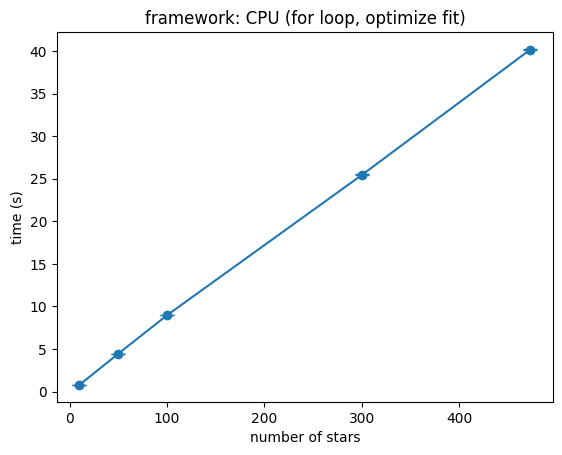

In [11]:
nb_stars = [473, 300, 100, 50, 10]
tps_for_CPU = [mean_time_for473, mean_time_for300, mean_time_for100, mean_time_for50, mean_time_for10]
statistical_error_for = [statistical_error_for473, statistical_error_for300, statistical_error_for100, statistical_error_for50, statistical_error_for10]

plt.errorbar(nb_stars, tps_for_CPU, yerr=statistical_error_for, fmt='-o', capsize=5)
plt.ylabel('time (s)')
plt.xlabel('number of stars')
plt.title('framework: CPU (for loop, optimize fit)')

In [12]:
def custom_function(row):
    """
    function for model fitting for each row of a dataframe
    
    Parameters:
    -----------
    row: pandas
        dataframe row
    
    Returns:
    -------
    fout.x: List
        optimized parameters
    model: arraylike
        optimized model
    residuals: arraylike
        residuals from real data minus optimized model
    """
    
    #create an image centered on a star
    x0 = int(round(row['x']))
    y0 = int(round(row['y']))
    left = x0 - (size // 2)
    top = y0 - (size // 2)
    right = left + size
    bottom = top + size  
    X = np.linspace(left, right, size) - x0
    Y = np.linspace(top, bottom, size) - y0
    X, Y = np.meshgrid(X, Y)
    pos = np.vstack((X.ravel(), Y.ravel()))
    stamp = qimg1[top:bottom, left:right]
    
    # fitting a gaussian model to the data
    to_fit = stamp / stamp.sum()
    fout = fits(params, to_fit.ravel())
    #print(f"Optimal parameters for index {row.name}: x0={fout.x[0]}, y0={fout.x[1]}, A={fout.x[2]}, sig_x={fout.x[3]}, sig_y={fout.x[4]}, b={fout.x[5]}")
    model = get_model(*fout.x).reshape(size, size)
    residuals = to_fit - model
    
    return fout.x, model, residuals

In [13]:
execution_times_pandas473 = []
for j in range(nb_iteration):
    debut = time.time()
    
    size = 17
    params = (0, 0, 1, 0.5, 1.0, 0) # initial parameters for the model
    results = qimg_catalog_isolated_mag_bord.apply(custom_function, axis=1)   
    
    fin = time.time()
    temps_execution_pandas473 = fin - debut
    #print(f"The code took {temps_execution_pandas473:.4f} seconds to execute.")
    execution_times_pandas473.append(temps_execution_pandas473)
    
std_dev_pandas473 = np.std(execution_times_pandas473)
statistical_error_pandas473 = std_dev_pandas473 / np.sqrt(nb_iteration)
mean_time_pandas473 = np.mean(execution_times_pandas473)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_pandas473:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_pandas473:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_pandas473:.4f} seconds.")

The average execution time over 100 iterations is 40.0756 seconds.
The standard deviation of execution times is 0.6292 seconds.
The statistical error of the execution time is 0.0629 seconds.


In [14]:
execution_times_pandas300 = []
for j in range(nb_iteration):
    debut = time.time()
    
    size = 17
    params = (0, 0, 1, 0.5, 1.0, 0) # initial parameters for the model
    total_images = 300 # number of data items selected in the dataframe
    end = qimg_catalog_isolated_mag_bord.head(total_images)
    results = end.apply(custom_function, axis=1)   
    
    fin = time.time()
    temps_execution_pandas300 = fin - debut
    #print(f"The code took {temps_execution_pandas300:.4f} seconds to execute.")
    execution_times_pandas300.append(temps_execution_pandas300)

std_dev_pandas300 = np.std(execution_times_pandas300)
statistical_error_pandas300 = std_dev_pandas300 / np.sqrt(nb_iteration)
mean_time_pandas300 = np.mean(execution_times_pandas300)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_pandas300:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_pandas300:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_pandas300:.4f} seconds.")

The average execution time over 100 iterations is 25.3133 seconds.
The standard deviation of execution times is 0.5173 seconds.
The statistical error of the execution time is 0.0517 seconds.


In [15]:
execution_times_pandas100 = []
for j in range(nb_iteration):
    debut = time.time()
    
    size = 17
    params = (0, 0, 1, 0.5, 1.0, 0) # initial parameters for the model
    total_images = 100 # number of data items selected in the dataframe
    end = qimg_catalog_isolated_mag_bord.head(total_images)
    results = end.apply(custom_function, axis=1)   
    
    fin = time.time()
    temps_execution_pandas100 = fin - debut
    #print(f"The code took {temps_execution_pandas200:.4f} seconds to execute.")
    execution_times_pandas100.append(temps_execution_pandas100)

std_dev_pandas100 = np.std(execution_times_pandas100)
statistical_error_pandas100 = std_dev_pandas100 / np.sqrt(nb_iteration)
mean_time_pandas100 = np.mean(execution_times_pandas100)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_pandas100:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_pandas100:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_pandas100:.4f} seconds.")

The average execution time over 100 iterations is 8.9970 seconds.
The standard deviation of execution times is 0.1862 seconds.
The statistical error of the execution time is 0.0186 seconds.


In [16]:
execution_times_pandas50 = []
for j in range(nb_iteration):
    debut = time.time()
    
    size = 17
    params = (0, 0, 1, 0.5, 1.0, 0) # initial parameters for the model
    total_images = 50 # number of data items selected in the dataframe
    end = qimg_catalog_isolated_mag_bord.head(total_images)
    results = end.apply(custom_function, axis=1)   
    
    fin = time.time()
    temps_execution_pandas50 = fin - debut
    #print(f"The code took {temps_execution_pandas100:.4f} seconds to execute.")
    execution_times_pandas50.append(temps_execution_pandas50)

std_dev_pandas50 = np.std(execution_times_pandas50)
statistical_error_pandas50 = std_dev_pandas50 / np.sqrt(nb_iteration)
mean_time_pandas50 = np.mean(execution_times_pandas50)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_pandas50:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_pandas50:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_pandas50:.4f} seconds.")

The average execution time over 100 iterations is 4.4437 seconds.
The standard deviation of execution times is 0.1357 seconds.
The statistical error of the execution time is 0.0136 seconds.


In [17]:
execution_times_pandas10 = []
for j in range(nb_iteration):
    debut = time.time()
    
    size = 17
    params = (0, 0, 1, 0.5, 1.0, 0) # initial parameters for the model
    total_images = 10 # number of data items selected in the dataframe
    end = qimg_catalog_isolated_mag_bord.head(total_images)
    results = end.apply(custom_function, axis=1)   

    
    fin = time.time()
    temps_execution_pandas10 = fin - debut
    #print(f"The code took {temps_execution_pandas50:.4f} seconds to execute.")
    execution_times_pandas10.append(temps_execution_pandas10)

std_dev_pandas10 = np.std(execution_times_pandas10)
statistical_error_pandas10 = std_dev_pandas10 / np.sqrt(nb_iteration)
mean_time_pandas10 = np.mean(execution_times_pandas10)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_pandas10:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_pandas10:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_pandas10:.4f} seconds.")

The average execution time over 100 iterations is 0.8049 seconds.
The standard deviation of execution times is 0.0449 seconds.
The statistical error of the execution time is 0.0045 seconds.


Text(0.5, 1.0, 'framework: CPU (pandas loop, optimize fit)')

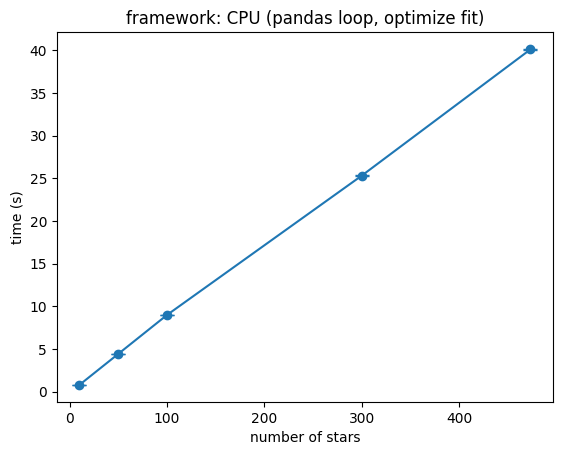

In [18]:
tps_pandas_CPU = [mean_time_pandas473, mean_time_pandas300, mean_time_pandas100, mean_time_pandas50, mean_time_pandas10]
statistical_error_pandas = [statistical_error_pandas473, statistical_error_pandas300, statistical_error_pandas100, statistical_error_pandas50, statistical_error_pandas10]

plt.errorbar(nb_stars, tps_pandas_CPU, yerr=statistical_error_pandas, fmt='-o', capsize=5)
plt.ylabel('time (s)')
plt.xlabel('number of stars')
plt.title('framework: CPU (pandas loop, optimize fit)')

# Sur GPU

In [19]:
import jax
import optax
import jax.numpy as jnp
from jax.scipy import stats as jstats

In [20]:
def get_stamps(dataframe, size=17):
    """
    Parameters:
    ----------
    dataframe: pandas.dataframe
        dataframe of stars's data from Gaia dr2
    size: int
        stamp size (17,17)

    Returns:
    --------
    stamps: np.asarray
        data of the star image
    """
    stamps = []
    for index, df in qimg_catalog_isolated_mag_bord.iterrows():
        x0 = int(round(df["x"]))
        y0 = int(round(df["y"]))
        left = x0 - (size // 2)
        top = y0 - (size // 2)
        right = left + size
        bottom = top + size
        stamps.append(qimg1[top:bottom, left:right])
    return np.asarray(stamps)

@jax.jit
def get_likelihood(params):
    """
    Computes the Chi squared from selected model 
    
    Parameters:
    ----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    --------
    summ: float
        chi squared
    """
    model = get_model(params)
    summ = jnp.sum((model - data)**2)
    return summ

@jax.jit
def get_logprob(params):
    """ 
    Computes the sum of the sigma probabilities and the chi squared
    
    Parameters:
    -----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    logprob: float
        sum of the sigma probabilities and the chi squared
    """
    logprior = -1* get_logprior(params) # to minimize
    likelihood = get_likelihood(params)
    logprob = logprior + likelihood
    return logprob

@jax.jit
def get_model(params):
    """
    returns the normalized Gaussian function
    =>
    Parameters:
    -----------
    params: pytree
        [mu: (2,N) centroids
         a: (N,) amplitudes
         b: (N,) backgrounbds
         pgrid: (N, size*size)
         sigmax: (1,) float
         sigmay: (1,) float
         ]
    Returns:
    -------
    model : arraylike
        the normalized Gaussian function
    """
    mu, a, b, sigmax, sigmay = params
    
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    norm = jstats.multivariate_normal.pdf(pos[None,:],  # same structure for all stars
                                      mean = mu[:,None], # one position per star
                                      cov = cov[None,:] # same cov for all stars
                                     )
    norm_model =  a[:,None]*norm + b[:,None] # (N, size*size)
    return norm_model

@jax.jit
def get_logprior(params):
    """
    Returns the probability to have sigmax and sigma y
    
    Parameters:
    -----------
    params: list
        selected model parameters
    
    Returns:
    -------
    logprior: float
        sum of the two sigma probabilities
    """
    mu, a, b, sigmax, sigmay = params
    logprior_sx = jstats.norm.logpdf(sigmax, loc=1, scale=0.5) # float
    logprior_sy = jstats.norm.logpdf(sigmay, loc=1, scale=0.5) # float
    logprior = logprior_sx + logprior_sy # get the maximize
    return logprior

In [21]:
def fit_tncg(func, init_param, 
             niter=10, tol=5e-3, 
             lmbda=1e2, 
             **kwargs):
    """ Hessian-free second order optimization algorithm

    The following implementation of TN-CG is largely based on
    recommendations given in Martens, James (2010, Deep learning via
    Hessian-free optimization, Proc. International  Conference on
    Machine Learning).

    Parameters
    ----------
    func: function
        function to minimize. Should return a float.

    init_param: 
        entry parameter of the input func

    niter: int
        maximum number of iterations

    tol: float
        targeted func variations below which the iteration will stop

    lmbda: float
        lambda parameter of the tncg algorithm. (optstate)

    **kwargs other func entries 

    Returns
    -------
    list
        - best parameters
        - loss (array)

    Example
    -------
    ```python
    import jax
    from edris import simulation, minimize
    key = jax.random.PRNGKey(1234)
    truth, simu = simulation.get_simple_simulation(key, size=1_000)

    def get_total_chi2(param, data):
        # model for a line with error on both axes but no intrinsic scatter.
        x_model = param["x_model"]
        y_model = x_model * param["a"] + param["b"]
    
        chi2_y = jnp.sum( ((data["x_obs"] - x_model)/data["x_err"])**2 )
        chi2_x = jnp.sum( ((data["y_obs"] - y_model)/data["y_err"])**2 )
    
        return chi2_y + chi2_x

    init_param = {"a": 8., "b":0., "x_model": simu["x_obs"]} # careful, must be float
    best_params, loss = minimize.fit_tncg(get_total_chi2, init_param, data=simu)
    ```
    
    """
    # handle kwargs more easily
    func_ = lambda x: func(x, **kwargs)
    fg = jax.value_and_grad(func_)
    
    # - internal function --- #
    def hessian_vector_product(g, x, v):
        return jax.jvp(g, (x,), (v,))[1]

    def step_tncg(x, optstate):
        loss, grads = fg(x)
        lmbda = optstate['lmbda']
        fvp = lambda v: jax.tree_util.tree_map (lambda d1, d2: d1 + lmbda*d2, hessian_vector_product(jax.grad(func_), x, v), v)
        updates, _ = jax.scipy.sparse.linalg.cg(fvp, grads, maxiter=50)
        coco = jax.tree_util.tree_reduce(lambda x, y: x+y, jax.tree_util.tree_map(lambda x, y: (-x*y).sum(), grads, updates))
        return updates, loss, optstate, coco

    step_tncg = jax.jit( step_tncg )
    # ----------------------- #
    
    x = init_param
    optstate = {'lmbda': lmbda}
    losses = []

    for i in range(niter):
        updates, loss, optstate, coco = step_tncg(x, optstate)
        x1 = jax.tree_util.tree_map(lambda x, y: x - y, x, updates)
        dloss = func_(x1) - loss
        losses.append(loss)
        rho = dloss / coco
        
        if rho < 0.25:
            optstate['lmbda'] = optstate['lmbda'] * 1.5
        elif rho > 0.75:
            optstate['lmbda'] = optstate['lmbda'] * 0.3
            
        if dloss < 0: # accept the step
            x = x1
            
        if tol is not None and dloss > -tol:
            break
        
    return x, losses

def fit_adam(func, init_params,
             learning_rate=5e-3, niter=200, 
             tol=1e-3,
             **kwargs):
    """ simple Adam gradient descent using optax.adam

    Parameters
    ----------
    func: function
        function to minimize. Should return a float.

    learning_rate: float
        learning rate of the gradient descent.
        (careful, results can be sensitive to this parameter)
        
    init_param: 
        entry parameter of the input func

    niter: int
        maximum number of iterations

    tol: float
        targeted func variations below which the iteration will stop

    **kwargs other func entries 

    Returns
    -------
    list
        - best parameters
        - loss (array)        
    """
    # handle kwargs more easily
    func_ = lambda x: func(x, **kwargs)
    
    # Initialize the adam optimizer
    params = init_params
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    opt_state = optimizer.init(params)
    
    grad_func = jax.jit(jax.grad( func_ )) # get the derivative
    
    # and do the gradient descent
    losses = []
    for i in range(niter):
        current_grads = grad_func(params)
        updates, opt_state = optimizer.update(current_grads, opt_state)
        params = optax.apply_updates(params, updates)
        losses.append( func_(params) ) # store the loss function
        if tol is not None and (i>2 and ((losses[-2] - losses[-1]) < tol)):
            break
            
    return params, losses


## fit Adam

In [22]:
execution_times_adam473 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord)
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    adam_params, adam_loss = fit_adam(get_logprob, guess, learning_rate=0.001, tol=1e-4, niter=1000)
    
    fin = time.time()
    temps_execution_adam473 = fin - debut
    #print(f"The code took {temps_execution_adam473:.4f} seconds to execute.")
    execution_times_adam473.append(temps_execution_adam473)

std_dev_adam473 = np.std(execution_times_adam473)
statistical_error_adam473 = std_dev_adam473 / np.sqrt(nb_iteration)
mean_time_adam473 = np.mean(execution_times_adam473)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_adam473:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_adam473:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_adam473:.4f} seconds.")

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Unable to load cuDNN. Is it installed?
Traceback (most recent call last):
  File "/pbs/throng/ccin2p3/ztf/site-packages-gpujax/jax/_src/xla_bridge.py", line 322, in _version_check
    version = get_version()
              ^^^^^^^^^^^^^
RuntimeError: cuDNN not found.

--------------------------------------------------
Outdated cuSOLVER installation found.
Version JAX was built against: 11504
Minimum supported: 11400
Installed version: 11101
The local installation version must be no lower than 11400. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


The average execution time over 100 iterations is 48.9654 seconds.
The standard deviation of execution times is 3.1728 seconds.
The statistical error of the execution time is 0.3173 seconds.


In [23]:
execution_times_adam300 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord.head(300))
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    adam_params, adam_loss = fit_adam(get_logprob, guess, learning_rate=0.001, tol=1e-4, niter=1000)
    
    fin = time.time()
    temps_execution_adam300 = fin - debut
    #print(f"The code took {temps_execution_adam300:.4f} seconds to execute.")
    execution_times_adam300.append(temps_execution_adam300)

std_dev_adam300 = np.std(execution_times_adam300)
statistical_error_adam300 = std_dev_adam300 / np.sqrt(nb_iteration)
mean_time_adam300 = np.mean(execution_times_adam300)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_adam300:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_adam300:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_adam300:.4f} seconds.")

The average execution time over 100 iterations is 48.6344 seconds.
The standard deviation of execution times is 2.7836 seconds.
The statistical error of the execution time is 0.2784 seconds.


In [24]:
execution_times_adam100 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord.head(100))
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    adam_params, adam_loss = fit_adam(get_logprob, guess, learning_rate=0.001, tol=1e-4, niter=1000)
    
    fin = time.time()
    temps_execution_adam100 = fin - debut
    #print(f"The code took {temps_execution_adam100:.4f} seconds to execute.")
    execution_times_adam100.append(temps_execution_adam100)

std_dev_adam100 = np.std(execution_times_adam100)
statistical_error_adam100 = std_dev_adam100 / np.sqrt(nb_iteration)
mean_time_adam100 = np.mean(execution_times_adam100)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_adam100:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_adam100:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_adam100:.4f} seconds.")

The average execution time over 100 iterations is 49.2248 seconds.
The standard deviation of execution times is 2.6593 seconds.
The statistical error of the execution time is 0.2659 seconds.


In [25]:
execution_times_adam50 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord.head(50))
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    adam_params, adam_loss = fit_adam(get_logprob, guess, learning_rate=0.001, tol=1e-4, niter=1000)
    
    fin = time.time()
    temps_execution_adam50 = fin - debut
    #print(f"The code took {temps_execution_adam50:.4f} seconds to execute.")
    execution_times_adam50.append(temps_execution_adam50)

std_dev_adam50 = np.std(execution_times_adam50)
statistical_error_adam50 = std_dev_adam50 / np.sqrt(nb_iteration)
mean_time_adam50 = np.mean(execution_times_adam50)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_adam50:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_adam50:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_adam50:.4f} seconds.")

The average execution time over 100 iterations is 49.0747 seconds.
The standard deviation of execution times is 2.6506 seconds.
The statistical error of the execution time is 0.2651 seconds.


In [26]:
execution_times_adam10 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord.head(10))
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    adam_params, adam_loss = fit_adam(get_logprob, guess, learning_rate=0.001, tol=1e-4, niter=1000)
    
    fin = time.time()
    temps_execution_adam10 = fin - debut
    #print(f"The code took {temps_execution_adam10:.4f} seconds to execute.")
    execution_times_adam10.append(temps_execution_adam10)

std_dev_adam10 = np.std(execution_times_adam10)
statistical_error_adam10 = std_dev_adam10 / np.sqrt(nb_iteration)
mean_time_adam10 = np.mean(execution_times_adam10)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_adam10:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_adam10:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_adam10:.4f} seconds.")

The average execution time over 100 iterations is 49.8054 seconds.
The standard deviation of execution times is 2.9614 seconds.
The statistical error of the execution time is 0.2961 seconds.


Text(0.5, 1.0, 'framework: GPU (adam fit)')

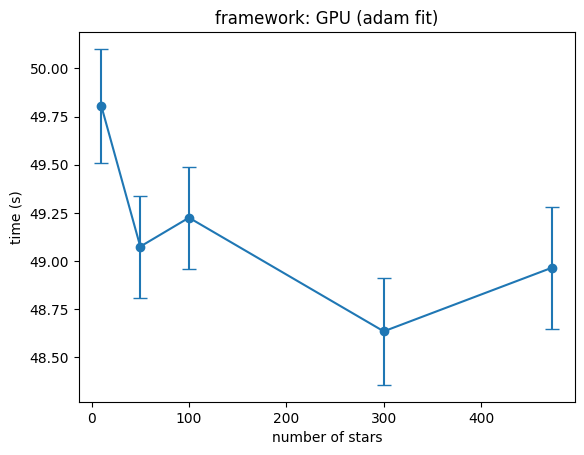

In [27]:
tps_adam_GPU = [mean_time_adam473, mean_time_adam300, mean_time_adam100, mean_time_adam50, mean_time_adam10]
statistical_error_adam = [statistical_error_adam473, statistical_error_adam300, statistical_error_adam100, statistical_error_adam50, statistical_error_adam10]

plt.errorbar(nb_stars, tps_adam_GPU, yerr=statistical_error_adam, fmt='-o', capsize=5)
plt.ylabel('time (s)')
plt.xlabel('number of stars')
plt.title('framework: GPU (adam fit)')

## fit tncg

In [28]:
execution_times_tncg473 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord)
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    tncg_params, tncg_loss = fit_tncg(get_logprob, guess, tol=1e-5, niter=50, lmbda=500)
    
    fin = time.time()
    temps_execution_tncg473 = fin - debut
    #print(f"The code took {temps_execution_tncg473:.4f} seconds to execute.")
    execution_times_tncg473.append(temps_execution_tncg473)

std_dev_tncg473 = np.std(execution_times_tncg473 )
statistical_error_tncg473 = std_dev_tncg473 / np.sqrt(nb_iteration)
mean_time_tncg473 = np.mean(execution_times_tncg473)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_tncg473:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_tncg473:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_tncg473:.4f} seconds.")

The average execution time over 100 iterations is 24.4468 seconds.
The standard deviation of execution times is 1.7303 seconds.
The statistical error of the execution time is 0.1730 seconds.


In [29]:
execution_times_tncg300 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord.head(300))
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    tncg_params, tncg_loss = fit_tncg(get_logprob, guess, tol=1e-5, niter=50, lmbda=500)
    
    fin = time.time()
    temps_execution_tncg300 = fin - debut
    #print(f"The code took {temps_execution_tncg300:.4f} seconds to execute.")
    execution_times_tncg300.append(temps_execution_tncg300)

std_dev_tncg300 = np.std(execution_times_tncg300)
statistical_error_tncg300 = std_dev_tncg300 / np.sqrt(nb_iteration)
mean_time_tncg300 = np.mean(execution_times_tncg300)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_tncg300:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_tncg300:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_tncg300:.4f} seconds.")

The average execution time over 100 iterations is 24.0054 seconds.
The standard deviation of execution times is 1.4514 seconds.
The statistical error of the execution time is 0.1451 seconds.


In [30]:
execution_times_tncg100 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord.head(100))
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    tncg_params, tncg_loss = fit_tncg(get_logprob, guess, tol=1e-5, niter=50, lmbda=500)
    
    fin = time.time()
    temps_execution_tncg100 = fin - debut
    #print(f"The code took {temps_execution_tncg100:.4f} seconds to execute.")
    execution_times_tncg100.append(temps_execution_tncg100)

std_dev_tncg100 = np.std(execution_times_tncg100)
statistical_error_tncg100 = std_dev_tncg100 / np.sqrt(nb_iteration)
mean_time_tncg100 = np.mean(execution_times_tncg100)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_tncg100:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_tncg100:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_tncg100:.4f} seconds.")

The average execution time over 100 iterations is 24.2412 seconds.
The standard deviation of execution times is 1.5415 seconds.
The statistical error of the execution time is 0.1542 seconds.


In [31]:
execution_times_tncg50 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord.head(50))
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    tncg_params, tncg_loss = fit_tncg(get_logprob, guess, tol=1e-5, niter=50, lmbda=500)
    
    fin = time.time()
    temps_execution_tncg50 = fin - debut
    #print(f"The code took {temps_execution_tncg50:.4f} seconds to execute.")
    execution_times_tncg50.append(temps_execution_tncg50)

std_dev_tncg50 = np.std(execution_times_tncg50)
statistical_error_tncg50 = std_dev_tncg50 / np.sqrt(nb_iteration)
mean_time_tncg50 = np.mean(execution_times_tncg50)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_tncg50:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_tncg50:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_tncg50:.4f} seconds.")

The average execution time over 100 iterations is 24.0850 seconds.
The standard deviation of execution times is 1.5357 seconds.
The statistical error of the execution time is 0.1536 seconds.


In [32]:
execution_times_tncg10 = []
for j in range(nb_iteration):
    debut = time.time()
    
    stamps = get_stamps(qimg_catalog_isolated_mag_bord.head(10))
    coefs = np.sum(stamps, axis=(1,2))
    stamps/=coefs[:,None, None]
    nstars = len(stamps)
    size= 17
    X = jnp.linspace(-size/2, size/2, size)
    Y = jnp.linspace(-size/2, size/2, size)
    X, Y = jnp.meshgrid(X, Y)
    pos = jnp.vstack((X.ravel(), Y.ravel())).T
    
    # guess
    data = stamps.reshape(len(stamps), -1)
    x0 = jnp.zeros((nstars,), dtype="float32")
    y0 = jnp.zeros((nstars,), dtype="float32")
    mu = np.vstack([x0,y0]).T
    sigmax, sigmay = 1., 1.
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
    a = jnp.ones((nstars,), dtype="float32")
    b = jnp.zeros((nstars,), dtype="float32")
    
    guess = [mu, a, b, sigmax, sigmay]
    tncg_params, tncg_loss = fit_tncg(get_logprob, guess, tol=1e-5, niter=50, lmbda=500)
    
    fin = time.time()
    temps_execution_tncg10 = fin - debut
    #print(f"The code took {temps_execution_tncg10:.4f} seconds to execute.")
    execution_times_tncg10.append(temps_execution_tncg10)

std_dev_tncg10 = np.std(execution_times_tncg10)
statistical_error_tncg10 = std_dev_tncg10 / np.sqrt(nb_iteration)
mean_time_tncg10 = np.mean(execution_times_tncg10)

print(f"The average execution time over {nb_iteration} iterations is {mean_time_tncg10:.4f} seconds.")
print(f"The standard deviation of execution times is {std_dev_tncg10:.4f} seconds.")
print(f"The statistical error of the execution time is {statistical_error_tncg10:.4f} seconds.")

The average execution time over 100 iterations is 24.0833 seconds.
The standard deviation of execution times is 1.4046 seconds.
The statistical error of the execution time is 0.1405 seconds.


Text(0.5, 1.0, 'framework: GPU (tncg fit)')

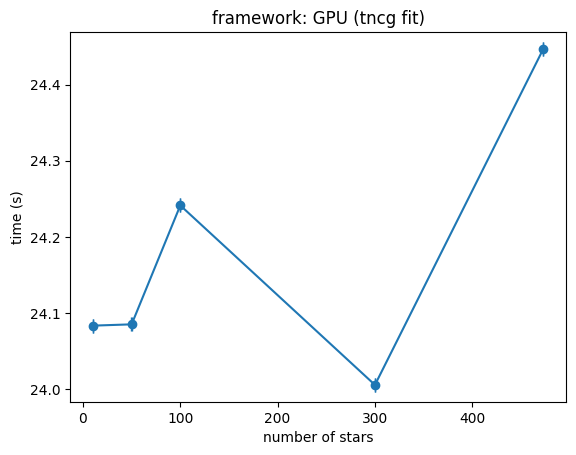

In [33]:
tps_tncg_GPU = [mean_time_tncg473, mean_time_tncg300, mean_time_tncg100, mean_time_tncg50, mean_time_tncg10]
statistical_error_tncg = [statistical_error_tncg473, statistical_error_tncg300, statistical_error_tncg100, statistical_error_tncg50, statistical_error_tncg10]

plt.errorbar(nb_stars, tps_tncg_GPU, xerr=statistical_error_tncg, fmt='-o', capsize=5)
plt.ylabel('time (s)')
plt.xlabel('number of stars')
plt.title('framework: GPU (tncg fit)')

# Summarize

Text(0.5, 1.0, 'Execution time as a function of number of stars and framework type')

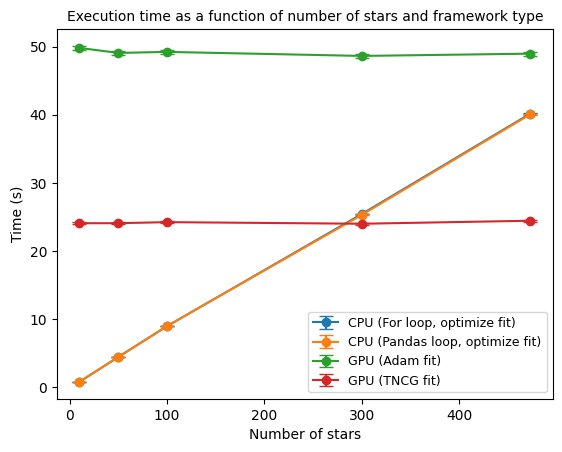

In [34]:
plt.errorbar(nb_stars, tps_for_CPU, yerr=statistical_error_for, fmt='-o', capsize=5, label='CPU (For loop, optimize fit)')
plt.errorbar(nb_stars, tps_pandas_CPU, yerr=statistical_error_pandas, fmt='-o', capsize=5, label='CPU (Pandas loop, optimize fit)')
plt.errorbar(nb_stars, tps_adam_GPU, yerr=statistical_error_adam, fmt='-o', capsize=5, label='GPU (Adam fit)')
plt.errorbar(nb_stars, tps_tncg_GPU, yerr=statistical_error_tncg, fmt='-o', capsize=5, label='GPU (TNCG fit)')
plt.legend(fontsize=9)
plt.xlabel('Number of stars')
plt.ylabel('Time (s)')
plt.title('Execution time as a function of number of stars and framework type', fontsize=10)

Text(0.5, 1.0, 'Execution time as a function of number of stars and framework type')

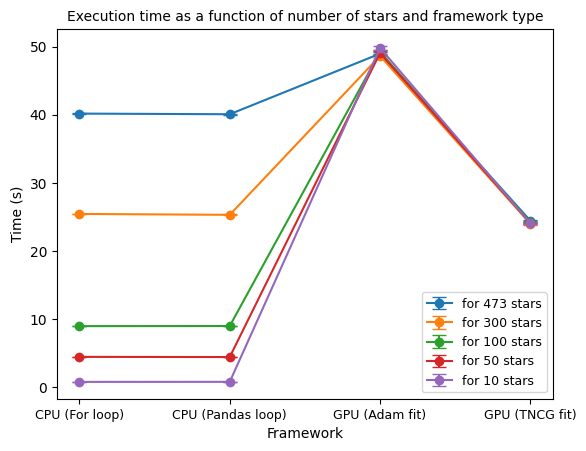

In [35]:
tps_473 = [mean_time_for473, mean_time_pandas473, mean_time_adam473, mean_time_tncg473]
tps_300 = [mean_time_for300, mean_time_pandas300, mean_time_adam300, mean_time_tncg300]
tps_100 = [mean_time_for100, mean_time_pandas100, mean_time_adam100, mean_time_tncg100]
tps_50 = [mean_time_for50, mean_time_pandas50, mean_time_adam50, mean_time_tncg50]
tps_10 = [mean_time_for10, mean_time_pandas10, mean_time_adam10, mean_time_tncg10]

statistical_error_473 = [statistical_error_for473, statistical_error_pandas473, statistical_error_adam473, statistical_error_tncg473]
statistical_error_300 = [statistical_error_for300, statistical_error_pandas300, statistical_error_adam300, statistical_error_tncg300]
statistical_error_100 = [statistical_error_for100, statistical_error_pandas100, statistical_error_adam100, statistical_error_tncg100]
statistical_error_50 = [statistical_error_for50, statistical_error_pandas50, statistical_error_adam50, statistical_error_tncg50]
statistical_error_10 = [statistical_error_for10, statistical_error_pandas10, statistical_error_adam10, statistical_error_tncg10]

framework = ['CPU (For loop)', 'CPU (Pandas loop)', 'GPU (Adam fit)', 'GPU (TNCG fit)']

plt.errorbar(framework, tps_473, yerr=statistical_error_473, fmt='-o', capsize=5, label='for 473 stars')
plt.errorbar(framework, tps_300, yerr=statistical_error_300, fmt='-o', capsize=5, label='for 300 stars')
plt.errorbar(framework, tps_100, yerr=statistical_error_100, fmt='-o', capsize=5, label='for 100 stars')
plt.errorbar(framework, tps_50, yerr=statistical_error_50, fmt='-o', capsize=5, label='for 50 stars')
plt.errorbar(framework, tps_10, yerr=statistical_error_10, fmt='-o', capsize=5, label='for 10 stars')
plt.legend(fontsize=9)
plt.xlabel('Framework')
plt.xticks(fontsize=9)
plt.ylabel('Time (s)')
plt.title('Execution time as a function of number of stars and framework type', fontsize=10)